In [ ]:
# time series prediction
# two tasks:
# predict tomorrow's price
# predict next week's price

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

In [24]:
# load data
df = pd.read_csv(
    'data/gas_price_2017_2023.csv',
    index_col = 'Date',
    parse_dates = ['Date'],
    date_parser = lambda dates: pd.to_datetime(dates, format = "%m/%d/%Y"))

In [25]:
df

,VANCOUVER
Date,
2017-01-02,130.6
2017-01-03,135.8
2017-01-04,135.9
2017-01-05,134.1
2017-01-06,135.5
...,...
2023-12-26,NaN
2023-12-27,NaN
2023-12-28,NaN


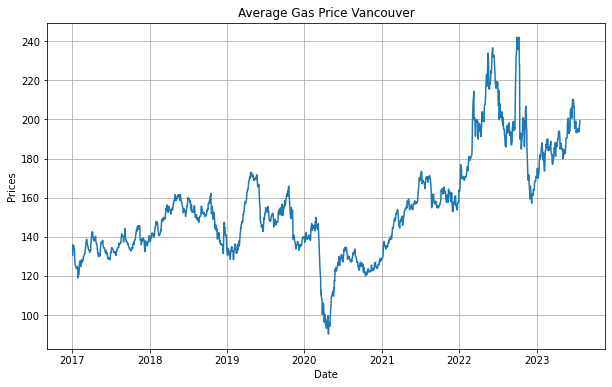

In [26]:
# plot price
plt.figure(figsize = (10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Prices')
plt.plot(df['VANCOUVER'])
plt.title('Average Gas Price Vancouver')
plt.show()

<AxesSubplot:ylabel='Density'>

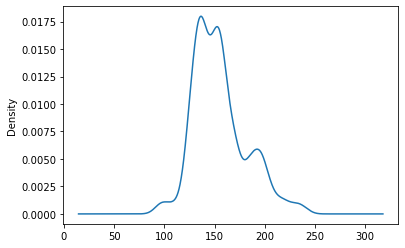

In [27]:
# distribution of dataset
df_price = df['VANCOUVER']
df_price.plot(kind = 'kde')

In [ ]:
# https://www.analyticsvidhya.com/blog/2021/07/stock-market-forecasting-using-time-series-analysis-with-arima-model/